In [189]:
%pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


Load lead data set  
Load street data set containing street direction location by Chicago grid address  
Load GeoJson file with Chicago neighborhood boundaries

In [190]:
df = pd.read_excel('lead.xlsx',skiprows=2,dtype={'Address': str, '1st Draw': str, '2/3 Min': str, '5 Min': str})
gdf = gpd.read_file("boundaries-zipcode.geojson")
df_streets = pd.read_csv('Streets.csv')
df.head()


,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,1000XX S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,100XX S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,100XX S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,100XX S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,100XX S AVENUE L,3.6,16,4.6


Replace X to 0

In [191]:
for i,row in df.iterrows():
    addr = row['Address']
    addr_l = addr.split()
    addr_l[0] = addr_l[0].replace('X','0')
    fixed_addr = ' '.join(addr_l)
    df.loc[i, 'Address'] = fixed_addr
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


Remove invalid row

In [192]:
df = df[df['1st Draw'].notna()]
df = df[df['2/3 Min'].notna()]
df = df[df['5 Min'].notna()]
df = df[df['1st Draw'] != ' ']
df = df[df['5 Min'] != ' ']
df = df[df['2/3 Min'] != ' ']
df = df[df['1st Draw'] != '']
df = df[df['5 Min'] != '']
df = df[df['2/3 Min'] != '']
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


remove '<' symbol

In [193]:
cols = ['1st Draw', '2/3 Min', '5 Min']
df[cols] = df[cols].applymap(lambda x: x.replace('<', '').strip() if isinstance(x, str) else x)
df['1st Draw'] = df['1st Draw'].astype(float)
df['2/3 Min'] = df['2/3 Min'].astype(float)
df['5 Min'] = df['5 Min'].astype(float)
df = df.sort_values('Sample Date', ascending=True).reset_index(drop=True)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00
...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50


In [194]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min'], dtype='object')

In [195]:
gdf.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')

In [196]:
gdf.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ..."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


extract address number into a new column. will be used to get coordinates

In [197]:
# Replace 'XX' with '00', then replace 'X' with '0', and extract street numbers
df['Address Num'] = df['Address'].str.replace('XX', '00').str.replace('X', '0').str.extract(r'(\d+)').fillna(0).astype(int)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100
...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700


In [198]:
# Extract the direction (N, S, E, W) from the 'Address' column
df['Address Dir'] = df['Address'].str.extract(r'\s([NSEW])\s')

# If the 'Address Dir' column contains any NaN values, fill them with an empty string
df['Address Dir'].fillna('', inplace=True)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S
...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N


extract street name for joining later on

In [199]:
# Extract the street name from the 'Address' column
df['Street Name'] = df['Address'].str.extract(r'[NSEW]\s(.+)$')
# Remove the asterisk (*) at the end of street names
df['Street Name'] = df['Street Name'].str.replace(r'\*$', '', regex=True)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE
...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE


add and fill coordinate columns (Lat, Lon)  
if the address direction is N or S, then add the Address Num to Lat  
if the address direction is E or W, then add the Address Num to Lon


In [200]:
# Add 'Lat' column
df['Lat'] = df.apply(lambda row: int(row['Address Num']) if 'N' in row['Address Dir'] or 'S' in row['Address Dir'] else None, axis=1)

# Add 'Lon' column
df['Lon'] = df.apply(lambda row: int(row['Address Num']) if 'E' in row['Address Dir'] or 'W' in row['Address Dir'] else None, axis=1)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN
...,...,...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN


In [201]:
df_streets.columns

Index(['Name', 'Street Dir', 'Street Num'], dtype='object')

In [202]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Address Num',
       'Address Dir', 'Street Name', 'Lat', 'Lon'],
      dtype='object')

make sure all street names are upper case before joining

In [203]:
df['Street Name'] = df['Street Name'].str.upper()
df_streets['Name'] = df_streets['Name'].str.upper()



In [204]:
merged_df = pd.merge(df, df_streets, left_on='Street Name', right_on='Name', how='left')


In [205]:
merged_df


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN,PARKSIDE AVE,W,5632.0


inspect any rows in the data frame

In [206]:
merged_df.iloc[20000:20010]


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,NaN,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,NaN,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,NaN,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,NaN,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,NaN,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,NaN,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,NaN,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,NaN,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,NaN,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,NaN,KEYSTONE AVE,W,4032.0


put the street number in the corresponding coordinate (Lat or Lon) 

In [207]:
merged_df['Lat'] = np.where(merged_df['Street Dir'].isin(['N', 'S']), merged_df['Street Num'], merged_df['Lat'])
merged_df['Lon'] = np.where(merged_df['Street Dir'].isin(['E', 'W']), merged_df['Street Num'], merged_df['Lon'])


inspect

In [208]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0


In [209]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0


we now have the city grid locations. we need to convert to gps coordinates  

In [210]:
base_lat = 41.8820500120278
base_lon = -87.62782737167875
# lat_factor = 0.0000174041
# lon_factor = 0.0000248416
lat_factor_N = 0.00001818932
lat_factor_S = 0.00001687716
lon_factor_E = 0.00002430679
lon_factor_W = 0.00002456658

# Create 'Lat GPS' column with computed values
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['N']) | merged_df['Address Dir'].isin(['N'])),
    base_lat + merged_df['Lat'] * lat_factor_N, merged_df['Lat']
)
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['S']) | merged_df['Address Dir'].isin(['S'])),
    base_lat - merged_df['Lat'] * lat_factor_S, merged_df['Lat GPS']
)

# Create 'Lon GPS' column with computed values
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['E']) | merged_df['Address Dir'].isin(['E'])),
    base_lon + merged_df['Lon'] * lon_factor_E, merged_df['Lon']
)
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['W']) | merged_df['Address Dir'].isin(['W'])),
    base_lon - merged_df['Lon'] * lon_factor_W, merged_df['Lon GPS']
)



In [211]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186


In [212]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0,41.898420,-87.625397
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0,41.916610,-87.803036
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0,41.918429,-87.642567
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0,41.740282,-87.573575
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0,41.753244,-87.711354
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0,41.989367,-87.803036
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0,41.875299,-87.721180
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0,41.689110,-87.718724
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0,41.945713,-87.770314
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0,41.898420,-87.726880


the dataset is now ready to be plotted on the geojson shape file

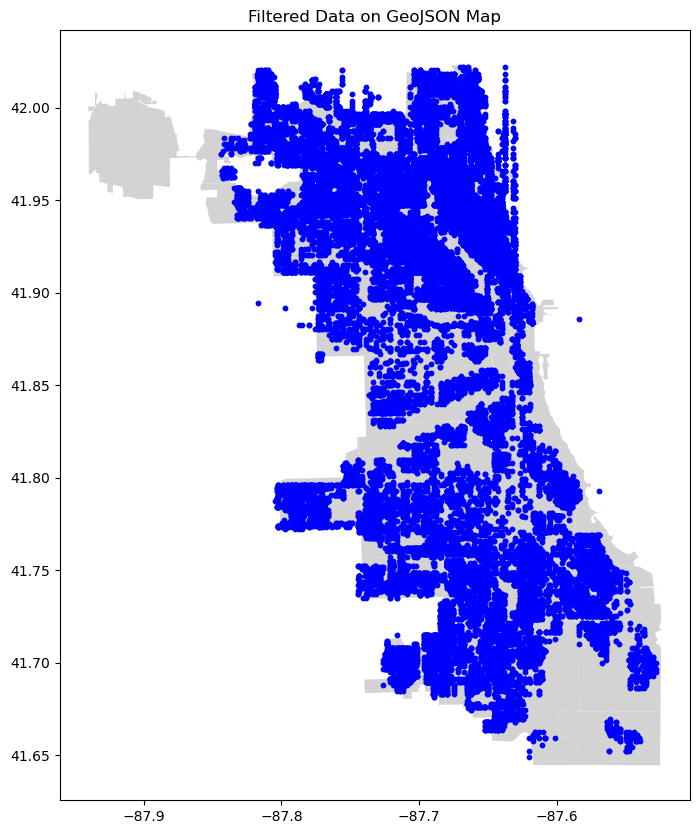

In [219]:
# Define your bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box

# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]

# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)

# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)

# Plot the GeoJSON data and the filtered points
ax = geojson_gdf.plot(color='lightgray', figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=10)

# You can customize the plot further if needed
plt.title("Filtered Data on GeoJSON Map")
plt.show()

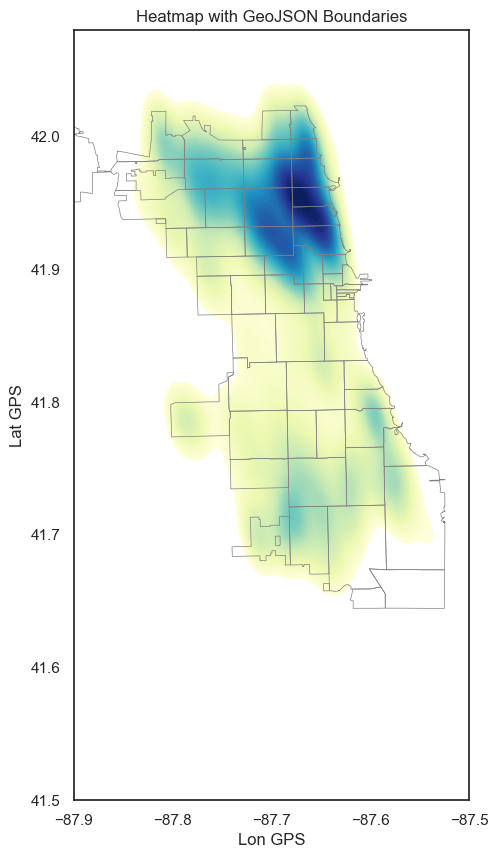

In [220]:

# Define your bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box

# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]

# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)

# Create a heatmap
sns.set(style="white")
plt.figure(figsize=(10, 10))
sns.kdeplot(data=gdf, x="Lon GPS", y="Lat GPS", fill=True, cmap="YlGnBu", levels=100)

# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)

# Plot the GeoJSON data on top of the heatmap
ax = geojson_gdf.plot(ax=plt.gca(), color='none', edgecolor='gray', linewidth=0.5)
ax.set_xlim(bounding_box[0], bounding_box[2])
ax.set_ylim(bounding_box[1], bounding_box[3])

plt.title("Heatmap with GeoJSON Boundaries")
plt.show()